# Exploratory Data Analysis - Intel Corporation (INTC) Stock Analysis

In [77]:
import pandas as pd
import numpy as np
import mplfinance as mpf
import matplotlib.pyplot as plt
import xgboost as xgb
import warnings

from copy import deepcopy as dc
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pandas.errors import SettingWithCopyWarning
from yahoofinancials import YahooFinancials


In [5]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [6]:
yahoo_financials = YahooFinancials('INTC')
data = yahoo_financials.get_historical_price_data("1980-01-01", "2024-12-31", "daily")

In [10]:
df = pd.DataFrame(data['INTC']['prices'])
df = df.drop('date', axis=1).set_index('formatted_date')
df.head()

,high,low,open,close,volume,adjclose
formatted_date,,,,,,
1980-03-17,0.330729,0.325521,0.325521,0.325521,10924800,0.181500
1980-03-18,0.328125,0.322917,0.325521,0.322917,17068800,0.180048
1980-03-19,0.335938,0.330729,0.330729,0.330729,18508800,0.184404
1980-03-20,0.334635,0.329427,0.330729,0.329427,11174400,0.183678
1980-03-21,0.322917,0.317708,0.322917,0.317708,12172800,0.177143


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11292 entries, 1980-03-17 to 2024-12-30
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   high      11292 non-null  float64
 1   low       11292 non-null  float64
 2   open      11292 non-null  float64
 3   close     11292 non-null  float64
 4   volume    11292 non-null  int64  
 5   adjclose  11292 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 617.5+ KB


In [29]:
df.describe()

,high,low,open,close,volume,adjclose
count,11292.000000,11292.000000,11292.000000,11292.000000,1.129200e+04,11292.000000
mean,20.617906,20.060830,20.338520,20.337192,5.063987e+07,14.987314
std,17.676666,17.199456,17.435263,17.434624,3.475509e+07,14.707935
min,0.218750,0.216146,0.218750,0.216146,0.000000e+00,0.120516
25%,1.484375,1.429688,1.458985,1.460938,2.745180e+07,0.814570
50%,20.990000,20.455000,20.709999,20.750000,4.456565e+07,12.742429
75%,31.360001,30.450001,30.942501,30.922500,6.459488e+07,22.612001
max,75.828125,73.625000,75.625000,74.875000,5.677088e+08,62.083336


In [37]:
df.index = pd.to_datetime(df.index)

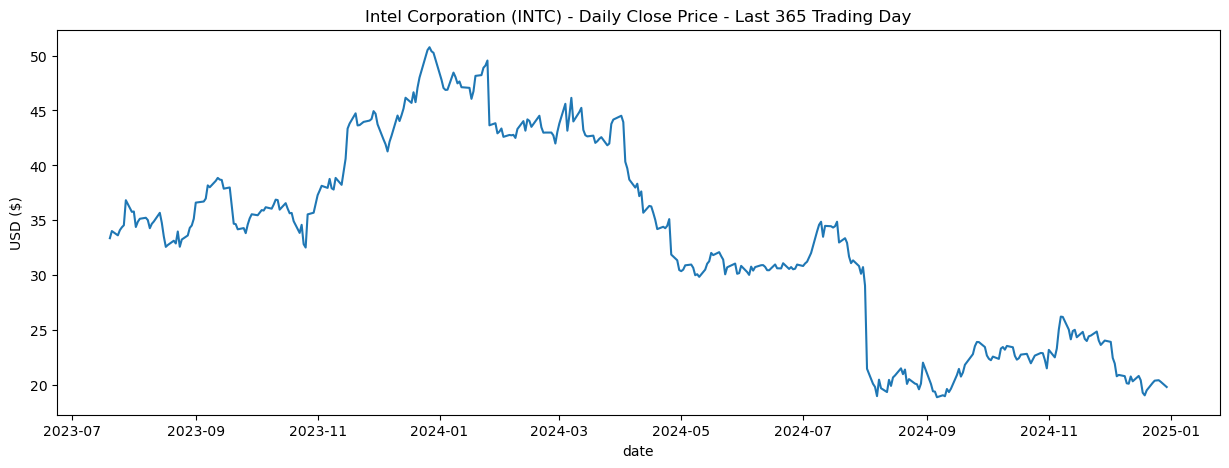

In [39]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Intel Corporation (INTC) - Daily Close Price - Last 365 Trading Day")

ax.plot(df.close[-365:])
ax.set_xlabel("date")
ax.set_ylabel("USD ($)")
plt.show()

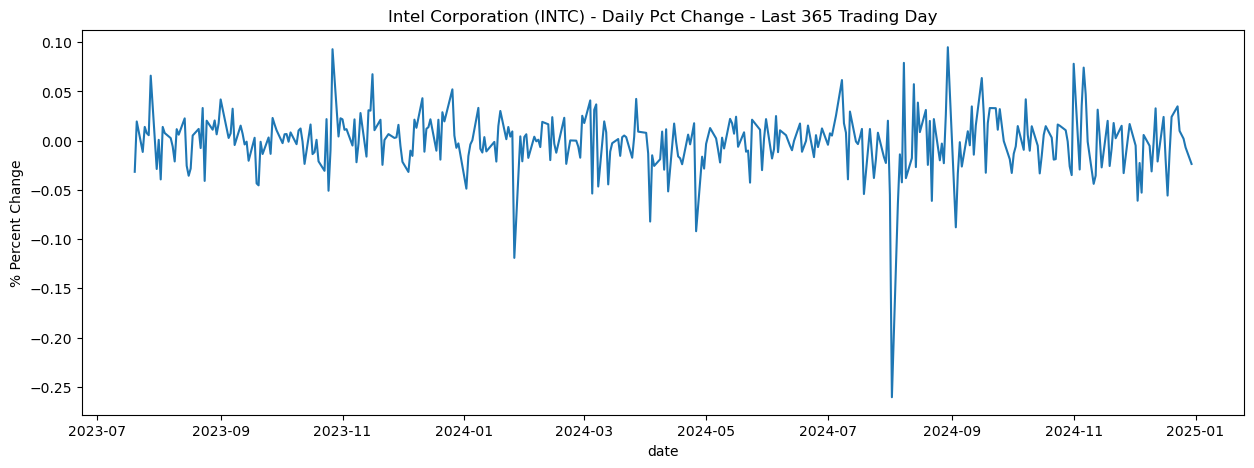

In [62]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Intel Corporation (INTC) - Daily Pct Change - Last 365 Trading Day")

ax.plot(df.close.pct_change()[-365:])
ax.set_xlabel("date")
ax.set_ylabel("% Percent Change")
plt.show()

In [40]:
df.insert(0, 'month', [date.strftime("%Y-%m") for date in df.index])
df.insert(0, 'year', [date.strftime("%Y") for date in df.index])

In [42]:
df_year = df.groupby("year").agg({"open": "min", "high":"max", "low":"min", "close":"mean", "volume": "sum"})

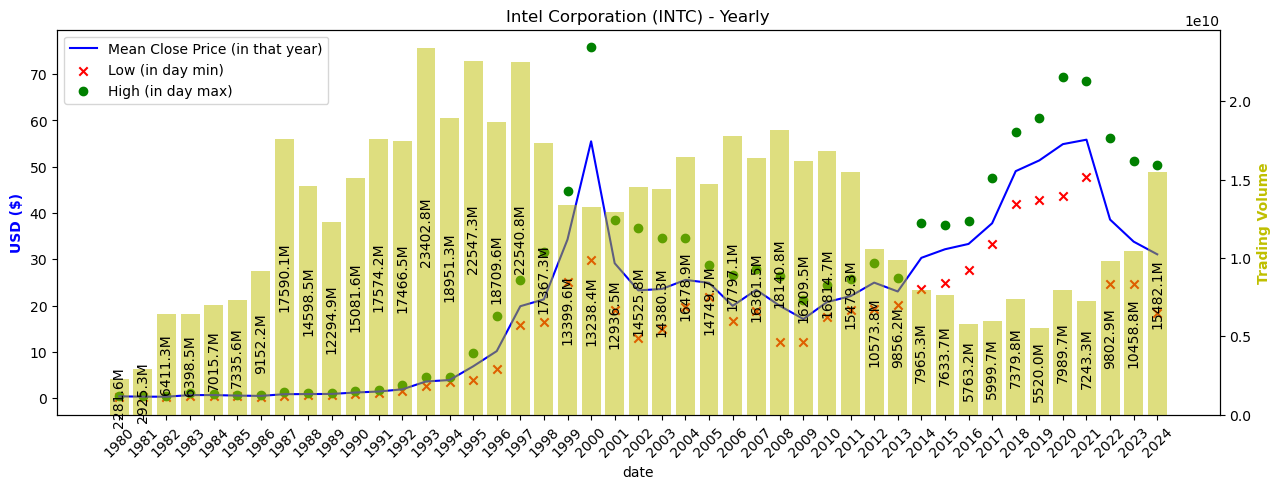

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Intel Corporation (INTC) - Yearly")
mean_close_price = ax.plot(df_year.close, label="Mean Close Price (in that year)", color="b")

low_per_year = ax.scatter(df_year.index, df_year.low, color="r", marker="x", label="Low (in day min)")
high_per_year = ax.scatter(df_year.index, df_year.high, color="g", marker="o", label="High (in day max)")

ax.set_xlabel("date")
ax.set_ylabel("USD ($)", color="b", fontweight="bold")
plt.xticks(rotation=45)

ax2 = ax.twinx()
bar_chart = ax2.bar(df_year.index, df_year.volume, color="y", label="Volume", alpha=0.5)


labels = [f'{val * 1e-6:.1f}M' for val in df_year['volume']]
ax2.bar_label(bar_chart, labels=labels, rotation=90, label_type="center", )
ax2.set_ylabel("Trading Volume", color="y", fontweight="bold")


ax.legend()
plt.show()

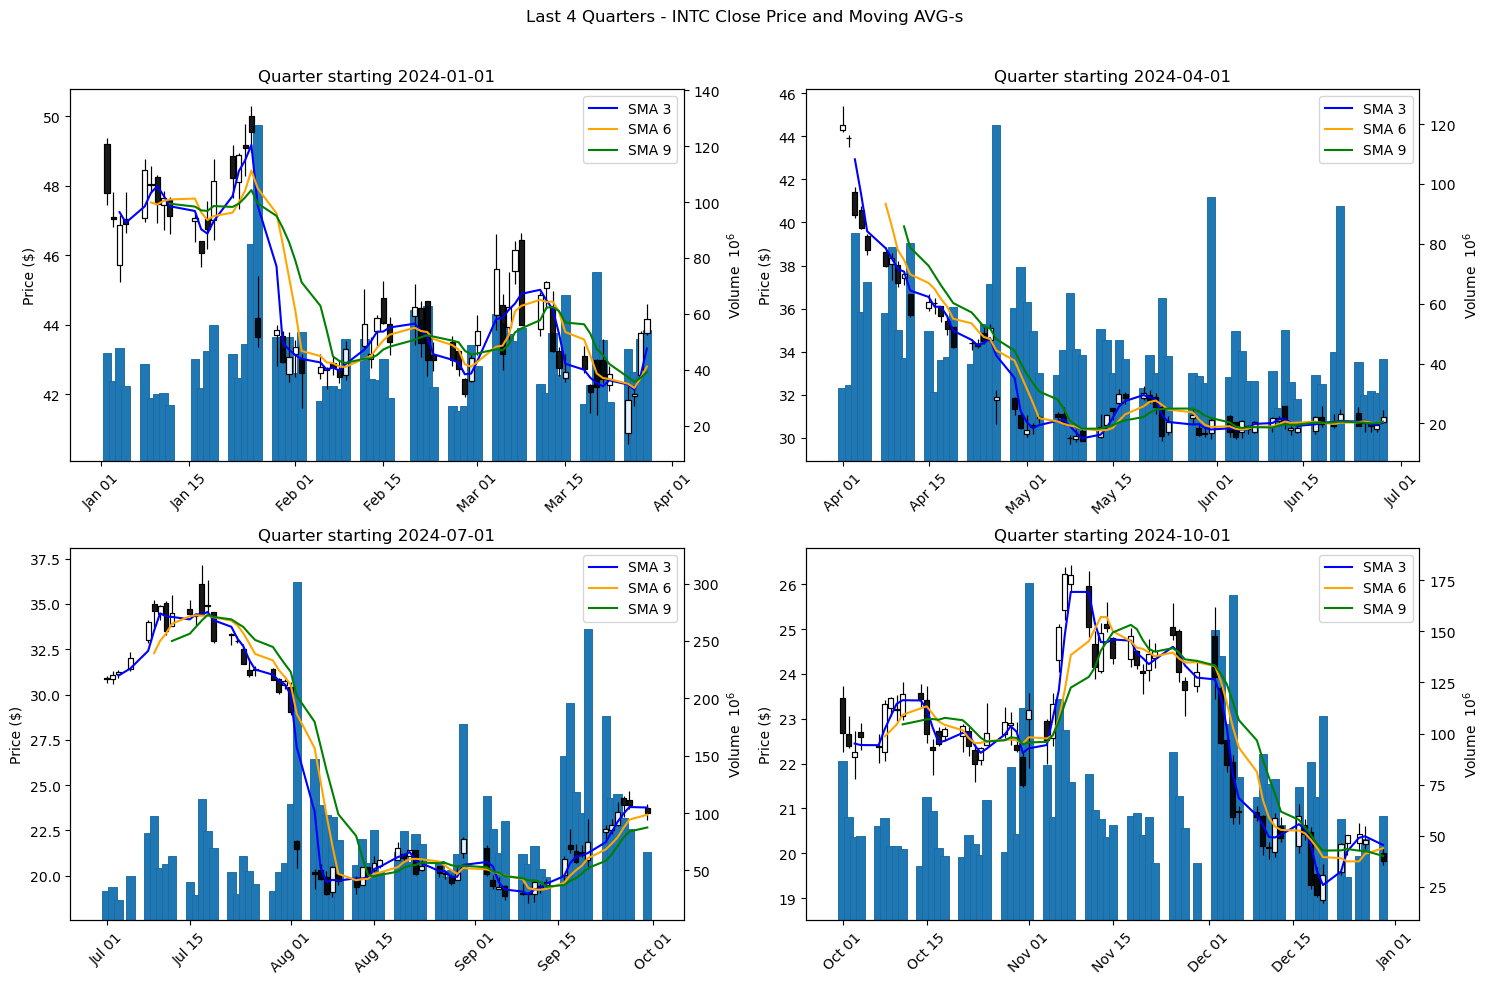

In [53]:
start_date = "2023-12-01"
quarters =  pd.date_range(start=start_date, periods=4, freq='3ME')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle("Last 4 Quarters - INTC Close Price and Moving AVG-s")

for i, ax in enumerate(axs.flatten()):
    start_q = quarters[i] + pd.Timedelta(days=1)

    if start_q == pd.to_datetime("2024-10-01"):
        df_quarter = df.loc[start_q:]
    else:
        end_q = quarters[i + 1]
        df_quarter = df.loc[start_q:end_q]

    ax_volume = ax.twinx()
    ax_volume.set_zorder(1)
    ax.set_zorder(2)
    ax.patch.set_visible(False)

    df_quarter.loc[:, 'SMA_3'] = df_quarter['close'].rolling(window=3).mean()
    df_quarter.loc[:, 'SMA_6'] = df_quarter['close'].rolling(window=6).mean()
    df_quarter.loc[:, 'SMA_9'] = df_quarter['close'].rolling(window=9).mean()

    mpf.plot(df_quarter, type='candle', ax=ax, volume=ax_volume, show_nontrading=True, ylabel="Price ($)")

    ax.plot(df_quarter.index, df_quarter['SMA_3'], label='SMA 3', color='blue')
    ax.plot(df_quarter.index, df_quarter['SMA_6'], label='SMA 6', color='orange')
    ax.plot(df_quarter.index, df_quarter['SMA_9'], label='SMA 9', color='green')

    ax.set_title(f'Quarter starting {start_q.date()}')
    ax.legend()

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Prediction with XGBRegressor

### Next Day Price based on past Open, High, Low, Close, Volume

In [63]:
df.drop(["year", "month", "adjclose"], axis=1, inplace=True)

In [64]:
df.tail()

,high,low,open,close,volume
formatted_date,,,,,
2024-12-23,20.230000,19.520000,19.580000,20.200001,57988400
2024-12-24,20.400000,19.959999,20.219999,20.400000,29884000
2024-12-26,20.670000,20.080000,20.230000,20.440001,39846200
2024-12-27,20.610001,20.090000,20.209999,20.299999,48260800
2024-12-30,20.110001,19.730000,20.010000,19.820000,59508400


In [ ]:
df_stationary = np.log(df).diff()
df_stationary.dropna(inplace=True)
df_stationary = df_stationary[[col for col in df_stationary if col != "close"] + ["close"]]

In [66]:
def is_stationary(timeseries):
    """
    Determines if a time series is stationary using the Augmented Dickey-Fuller (ADF) test.

    Returns:
    bool: True if the time series is stationary, False otherwise.
    """

    adf_result = adfuller(timeseries)
    test_statistic = adf_result[0]
    critical_values = adf_result[4]
    df_output = pd.Series(adf_result[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    
    for key, value in adf_result[4].items():
        df_output["Critical Value (%s)"%key] = value
        
    if test_statistic < critical_values['5%']:  ## 5% significance level
        print(True)
    else:
        print(False)


In [67]:
df_stationary.replace([np.inf, -np.inf], np.nan, inplace=True)

In [68]:
df_stationary.volume = df_stationary.volume.interpolate()

In [69]:
df_stationary.isna().sum()

high      0
low       0
open      0
volume    0
close     0
dtype: int64

In [70]:
for col in df_stationary:
    is_stationary(df_stationary.loc[:, col])

True
True
True
True
True


In [71]:
def create_past_features(dataframe, predicted_column, n_past=int):

    df_shifted = dc(dataframe)
    
    features = df_shifted.columns.to_list()
    
    for feature in features:
        for i in range(1, n_past + 1):
            df_shifted[f"{feature}_(t-{i})"] = df_shifted[feature].shift(i)

    features.remove(predicted_column)
    df_shifted.drop(features, axis=1, inplace=True)

    df_shifted = df_shifted[[col for col in df_shifted if col != predicted_column] + [predicted_column]]
    
    df_shifted.dropna(inplace=True)
    return df_shifted   

In [73]:
tscv = TimeSeriesSplit(n_splits=2500, test_size=1, gap=0)  # Number of splits, test_size=1 (1 day prediction),  gap=1 

In [74]:
predictions = []
true_values = []
i = 0

for train_index, test_index in tscv.split(df_stationary):

    model = xgb.XGBRegressor()

    train = df_stationary.iloc[train_index]
    test = df_stationary.iloc[[test_index-7][0][0]:test_index[0]+1]

    if i == 0:
        first_test_date = test.index[-1]
        i += 1
        
    scaler = MinMaxScaler()
    train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns)
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns)
    
    # Past 7 Days
    train_shifted = create_past_features(train_scaled, "close", n_past=7)
    test_shifted = create_past_features(test_scaled, "close", n_past=7)

    train_X, train_y = train_shifted.iloc[:, :-1], train_shifted.iloc[:, -1]
    test_X, test_y = test_shifted.iloc[:, :-1], test_shifted.iloc[:, -1]

    model.fit(train_X, train_y)
    
    y_pred = model.predict(test_X)

    y_pred_unscaled = scaler.inverse_transform(np.concatenate([np.ones((1, len(test.columns)-1)), y_pred.reshape(1, -1)], axis=1))[:, -1][0]

    y_pred_exp = np.exp(np.log(df.loc[test.index[-2]].close) + y_pred_unscaled)
    y_true = df.loc[test.index[-1]].close

    predictions.append(y_pred_exp)
    true_values.append(y_true)

    print(train.index[-1], flush=True, end="\r")
    
    del model, scaler

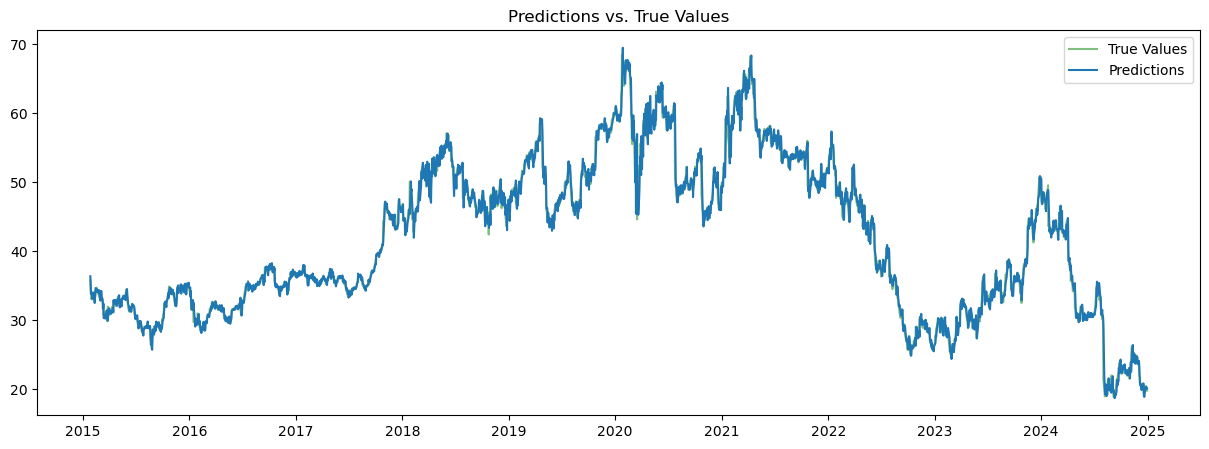

In [75]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Predictions vs. True Values")
ax.plot(df[first_test_date:].index, df[first_test_date:].close, color="g", label="True Values", alpha=0.5)
ax.plot(df[first_test_date:].index, predictions, label="Predictions")

ax.legend()
plt.show()

In [76]:
mean_squared_error(true_values, predictions)

1.1327064023688003

In [80]:
root_mean_squared_error(true_values, predictions)

1.0642868045638827

In [81]:
mean_absolute_error(true_values, predictions)

0.6872332339755706

In [82]:
mean_absolute_percentage_error(true_values, predictions)

0.016554318660217317

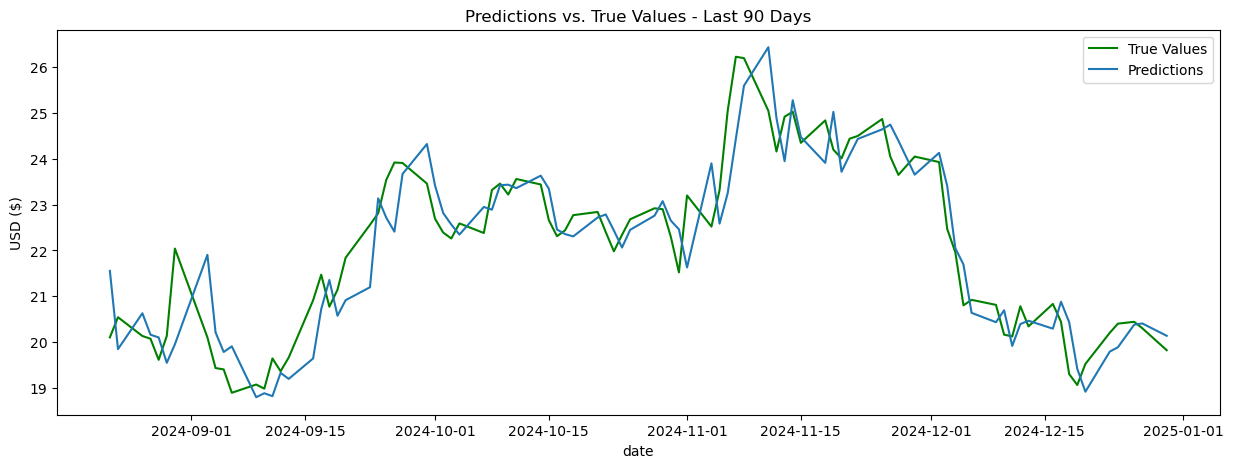

In [83]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Predictions vs. True Values - Last 90 Days")
ax.plot(df.iloc[-90:].index, df.iloc[-90:].close, color="g", label="True Values")
ax.plot(df.iloc[-90:].index, predictions[-90:], label="Predictions")

ax.set_xlabel("date")
ax.set_ylabel("USD ($)")
ax.legend()
plt.show()

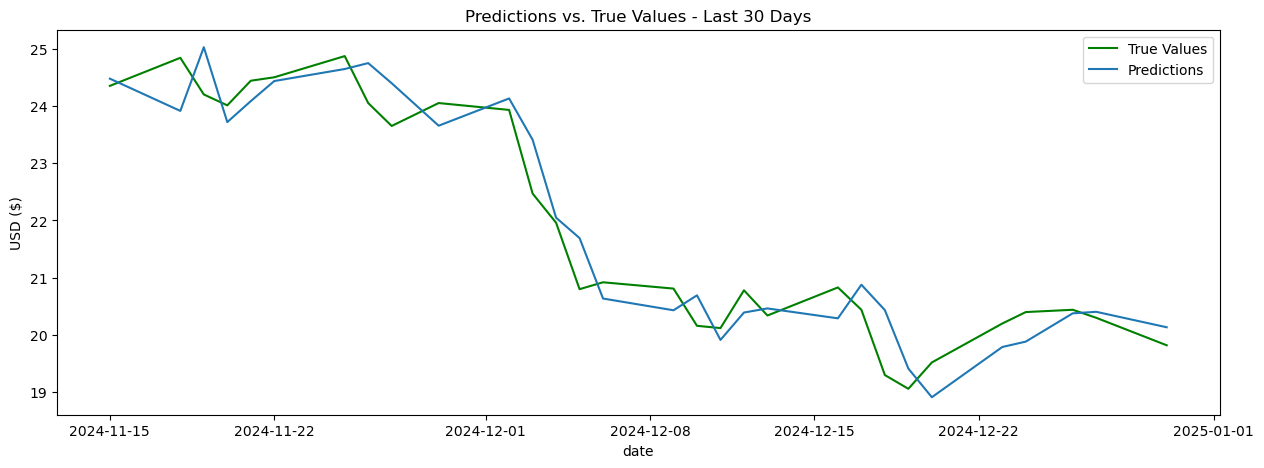

In [86]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title("Predictions vs. True Values - Last 30 Days")
ax.plot(df.iloc[-30:].index, df.iloc[-30:].close, color="g", label="True Values")
ax.plot(df.iloc[-30:].index, predictions[-30:], label="Predictions")

ax.set_xlabel("date")
ax.set_ylabel("USD ($)")
ax.legend()
plt.show()